In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from scipy import stats
import sys
import sklearn
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [74]:
sys.path.insert(0, '/Users/cynthiachen/Downloads/Internship2019/degron_mutation/deepDegron')
from train_nn import *

In [401]:
wd = '/Users/cynthiachen/Downloads/Internship2019/degron_mutation/'

In [167]:
# Load pre-trained neural network models from pickle file
model_bag_of_words = pickle.load(open( "../models/neural_network_bag_of_words_v2.pickle", "rb" ))
model_pos_specific = pickle.load(open( "../models/neural_network_pos_specific_v2.pickle", "rb" ))

# Create pd dataframe of sequence information 
degron_pred = pd.read_csv("../data/degron_pred.csv", index_col=0)
# Select column of input sequences
input_seq = degron_pred.iloc[:, 10]

In [76]:
# Use compute_feature_matrix function to encode sequences
features = compute_feature_matrix(input_seq, 6, True)
condensed_features = features[:, 0:20] # Remove zeros at the end for bag of words prediction

In [77]:
# Use pre-trained model to predict sequence degredataion
pred_bow_wt = model_bag_of_words.predict_proba(condensed_features) # wild-type bag of words prediction
pred_ps_wt = model_pos_specific.predict_proba(features)            # wild-type position-specific prediction
drp_wt = pred_ps_wt-pred_bow_wt                                    # wild-type degron regulatory potential

In [78]:
# def mutate(seq, index, newchar):
#     char_list = list(seq)
#     char_list[index] = newchar
#     return "".join(char_list)

In [79]:
# Convert string to 2D list of characters

seqlist = [] # 2D list of all sequences, with each character as 1 entry 
for sequence in input_seq:
    seqlist.append(list(sequence))

### Mutation 1: Shift mutation
Shifts all the characters at a certin position down by 1 sequence, with the first sequence filled by the last sequence

In [80]:
seq_length = len(seqlist[0]) # 23
num_seq = len(seqlist)       # number of total sequences
shift = 1                    # distance to shift characters by

# List that contains the delta DRP for each position when a shift mutation occurs at that position
diff=[]

# Loop to iterate through all sequence positions
for p in range(seq_length):
    first = seqlist[0][pos]
    for i in range(num_seq-shift):
        #for j in range(seq_length) - iterate through positions
        seqlist[i][pos] = seqlist[i+shift][pos]
    seqlist[num_seq-shift][pos]=first
    
    mutated_seqs = []
    for i in range(num_seq):
        mutated_seqs.append("".join(seqlist[i])) 
        
    # Use compute_feature_matrix function to encode sequences
    features = compute_feature_matrix(pd.Series(mutated_seqs), 6, True)
    condensed_features = features[:, 0:20] # Remove zeros at the end for bag of words prediction

    # Use pre-trained model to predict sequence degredataion
    # Use pre-trained model to predict sequence degredataion
    pred_bow_mut = model_bag_of_words.predict_proba(condensed_features) # bag of words prediction
    pred_ps_mut = model_pos_specific.predict_proba(features)            # position-specific prediction
    drp_mut = pred_ps_mut-pred_bow_mut                                  # mutated degron regulatory potential
    
    # Calculate DRP difference in mutated and wild-type (normal) sequence and add this to a list
    diff.append(drp_wt-drp_mut)

In [82]:
average_delta = []
for i in diff:
    average_delta.append(np.average(i))

In [84]:
# # Plot histogram showing distribution of average DRP deltas

# sns.set(color_codes=True)
# x = np.random.normal(size=200)
# sns.distplot(diff)
# plt.show()

# sns.set(color_codes=True)
# x = np.random.normal(size=200)
# sns.distplot(average_delta, bins = 8)
# plt.show()

### Mutation 2: Random shuffle mutation (considering only Top & Bottom scores)
Shifts all the characters at a certain position using random shuffling, and then considers only the select top and bottom sequences

In [243]:
# Sort degron sequence information by regulatory potential in descending order (highest to lowest)
degron_pred_sorted = degron_pred.sort_values(by=['regulatory potential'], ascending=False)

In [244]:
# Select only the "sequence" and "potential" columns and format values into a list
degron_seq_scores = degron_pred_sorted[['Peptide amino acid sequence','regulatory potential']].values.tolist()

### ROC curve calculation to statistically determine sequence cutoff

In [ ]:
# roc_auc_score

In [369]:
# Determines true labels based on bins
# Bins 1 & 2 -> 1 (high degradation)
# Bins 3 & 4 -> 0 (low degradation)

auc_info = np.asarray(degron_pred_sorted[['Modal Bin','sequence position specific', 'bag of words']])

for i in range(num_seq):
    mbin = auc_info[:, 0][i]
    if mbin > 2:
        auc_info[:, 0][i] = 0
    else:
        auc_info[:, 0][i] = 1

In [269]:
# y_true = auc_info[:, 0]
# y_score_ss = auc_info[:, 1] # Sequence-specific prediction scores
# y_score_bow = auc_info[:, 2] # Bag of words prediction scores

# fp_ss, tp_ss, _ = sklearn.metrics.roc_curve(y_true, y_score_ss)
# auc_ss = roc_auc_score(fp_ss, tp_ss)
# fp_bow, tp_bow, _ = sklearn.metrics.roc_curve(y_true, y_score_bow)
# auc_bow = roc_auc_score(fp_bow, tp_bow)

In [279]:
# auc_info[50:, 1]

array([ 0.6864157 ,  0.9275128 ,  0.8683737 , ...,  0.06270089,
        0.07536349,  0.05815238])

In [385]:
def delta_auc(cutoff):
    y_true = auc_info[cutoff:, 0]
    y_score_ss = auc_info[cutoff:, 1] # Sequence-specific prediction scores
    y_score_bow = auc_info[cutoff:, 2] # Bag of words prediction scores

    fp_ss, tp_ss, _ = sklearn.metrics.roc_curve(y_true, y_score_ss) # false-positive and true-positive
    auc_ss = auc(fp_ss, tp_ss)
    fp_bow, tp_bow, _ = sklearn.metrics.roc_curve(y_true, y_score_bow)
    auc_bow = auc(fp_bow, tp_bow) 
    
    return auc_ss - auc_bow

def plot_auc(cutoff, fp_ss, tp_ss, auc_ss, fp_bow, tp_bow, auc_bow):
    plt.figure()
    lw = 2
    plt.plot(fp_ss, tp_ss, color='darkorange',
             lw=lw, label='Sequence-specific (area = %0.3f)' % auc_ss)
    plt.plot(fp_bow, tp_bow, color='darkgreen',
             lw=lw, label='Bag-of-words (area = %0.3f)' % auc_bow)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic, Cutoff = ' + str(cutoff))
    plt.legend(loc="lower right")
    plt.show()

In [412]:
# Determine delta AUC values for all cutoffs to determine the minimum AUC

aucs = []
num_cutoffs = 50
increment = 100
cutoffs = np.asarray(range(num_cutoffs)) * increment

for c in cutoffs:
    aucs.append(delta_auc(c))
    
#fig = plt.figure()
sns.set_style("darkgrid")
plt.plot(cutoffs, aucs)
plt.xlabel('Cutoff')
plt.ylabel('Delta AUC')

min_index = np.argmin(np.asarray([cutoffs, aucs])[1])
min_cutoff = int(combined[0][min_index]) # cutoff for the minimum difference betweeen SS and BOW

plt.plot(min_cutoff, combined[1][min_index], 'ro')
# ax = fig.add_subplot(111)
# an2 = ax.annotate("Minimum", xy=(min_cutoff, combined[1][min_index]), 
#                   xycoords=an1,
#                   xytext=(0.5,1.1), textcoords=(an1, "axes fraction"),
#                   va="bottom", ha="center",
#                   bbox=dict(boxstyle="round", fc="w"),
#                   arrowprops=dict(arrowstyle="->"))
delta = u'Δ'
plt.title(delta + ' AUC at Various Cutoffs')
    
plt.savefig(wd+'figures/delta_auc_over_cutoffs',dpi=300)

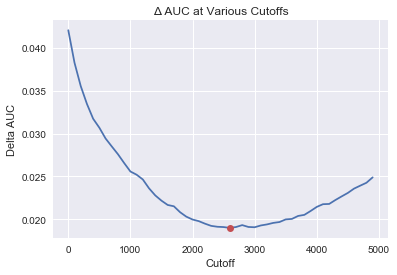

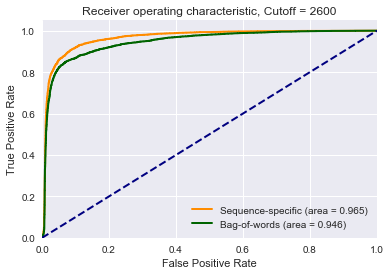

In [413]:
# Plot ROC curve for cutoff with minimum delta AUC

y_true = auc_info[min_cutoff:, 0]
y_score_ss = auc_info[min_cutoff:, 1] # Sequence-specific prediction scores
y_score_bow = auc_info[min_cutoff:, 2] # Bag of words prediction scores

fp_ss, tp_ss, _ = sklearn.metrics.roc_curve(y_true, y_score_ss)
auc_ss = auc(fp_ss, tp_ss)
fp_bow, tp_bow, _ = sklearn.metrics.roc_curve(y_true, y_score_bow)
auc_bow = auc(fp_bow, tp_bow)

plot_auc(min_cutoff, fp_ss, tp_ss, auc_ss, fp_bow, tp_bow, auc_bow)

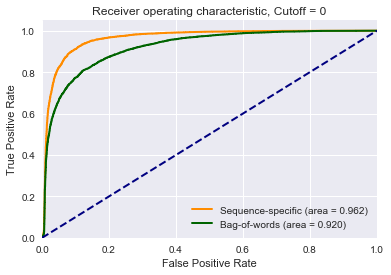

In [414]:
y_true = auc_info[:, 0]
y_score_ss = auc_info[:, 1] # Sequence-specific prediction scores
y_score_bow = auc_info[:, 2] # Bag of words prediction scores

fp_ss, tp_ss, _ = sklearn.metrics.roc_curve(y_true, y_score_ss)
auc_ss = auc(fp_ss, tp_ss)
fp_bow, tp_bow, _ = sklearn.metrics.roc_curve(y_true, y_score_bow)
auc_bow = auc(fp_bow, tp_bow)

plot_auc(0, fp_ss, tp_ss, auc_ss, fp_bow, tp_bow, auc_bow)

### Motif Analysis
Discover patterns that characterize sequences with high & low degron regulatory potential

In [93]:
# Sort degron sequence information by regulatory potential in descending order (highest to lowest)
degron_pred_sorted = degron_pred.sort_values(by=['regulatory potential'], ascending=False
                                             
# Select only the "sequence" and "potential" columns and format values into a list
degron_seq_scores = degron_pred_sorted[['Peptide amino acid sequence','regulatory potential']].values.tolist()

In [217]:
# Function description: 
#
# Cutoff -- number of sequences from the top + bottom to consider for motif analysis
# Motif length -- length of kmer motifs to be considered

def motif(cutoff = 50, motif_length = 2):
    top = degron_seq_scores[0:cutoff]
    bottom = degron_seq_scores[-cutoff:]
    kmers = []
    kmer_dict = {}
    
    for row in top:
        sequence = row[0]
        for j in range(seq_length - motif_length + 1):
            kmers.append((sequence[j:(j+motif_length)], row[1])) # add k-mer and corresponding score
    
    # Normalize drp scores to emphasize differences
    kmers = np.asarray(kmers) # Convert kmers to np array from a list
    x = np.asarray(list(map(float, kmers[:, 1])))
    normalized = (x-min(x))/(max(x)-min(x))
    kmers[:,1] = normalized
    
    # Convert list of kmers into 1 string
    kmer_str = " ".join(kmers[:, 0])
    kmer_list = list(kmers[:, 0])
    
    unique_kmers = [] 
  
    # Determine all unique kmers
    for i in kmer_list: 
        # checking for duplicacy 
        if i not in unique_kmers: 
            # insert value in str2 
            unique_kmers.append(i)  
    
    for i in range(0, len(unique_kmers)): 
        # count the frequency of each unique kmer and print 
        #print('Frequency of', unique_kmers[i], 'is :', kmer_list.count(unique_kmers[i]))
        kmer_dict.update({unique_kmers[i] : kmer_list.count(unique_kmers[i])})
    
    # Returns dictionary of [kmer sequence] -> [frequency]
    return kmer_dict

In [ ]:
d = motif()
sorted(d.items(), key=lambda item: item[1])

Motif analysis with DRP score weighting

In [204]:
# Function description: 
#
# Cutoff -- number of sequences from the top + bottom to consider for motif analysis
# Motif length -- length of kmer motifs to be considered

def motif_with_weighting(cutoff = 50, motif_length = 2):
    top = degron_seq_scores[0:cutoff]
    bottom = degron_seq_scores[-cutoff:]
    kmers = []
    
    for row in top:
        sequence = row[0]
        for j in range(seq_length - motif_length + 1):
            kmers.append((sequence[j:(j+motif_length)], row[1])) # add k-mer and corresponding score
    
    # Normalize drp scores to emphasize differences
    kmers = np.asarray(kmers) # Convert kmers to np array from a list
    x = np.asarray(list(map(float, kmers[:, 1])))
    normalized = (x-min(x))/(max(x)-min(x))
    kmers[:,1] = normalized
    
    # Convert list of kmers into 1 string
    kmer_str = " ".join(kmers[:, 0])
    kmer_list = list(kmers[:, 0])
    
    unique_kmers = [] 
  
    # Determine all unique kmers
    for i in kmer_list: 
        # checking for duplicacy 
        if i not in unique_kmers: 
            # insert value in str2 
            unique_kmers.append(i)  
    
    for i in range(0, len(unique_kmers)): 
        # 
        np.asarrray
        kmer_dict.update({unique_kmers[i] : kmer_list.count(unique_kmers[i])})